# [E-05] 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

이번 프로젝트는 Kaggle 사이트에서 진행했던 대회에 가상으로 참가하여 주어진 데이터와 가이드라인을 활용하여 목표 점수에 도달하는 것을 목표로 한다.
<hr>

## 라이브러리와 데이터 불러오기

In [1]:
# 라이브러리 불러오기
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [3]:
# date 컬럼 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<hr>

## 데이터 살펴보기

pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴본다.

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [4]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(test_data_path)
print('train data dim : {}'.format(data.shape))
print('test data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


### 변수 정리

In [5]:
# target 데이터인 price를 y로 저장
y = train['price']
del train['price']

# 필요없는 id 삭제
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
# test data도 같은 방법으로 전처리

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<hr>

## 데이터 전처리

각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단한 전처리 작업을 진행한다.

### 결측치 확인

missingno 라이브러리의 matrix 함수를 사용하여 데이터의 결측 상태를 시각화하여 살펴본다.

<AxesSubplot:>

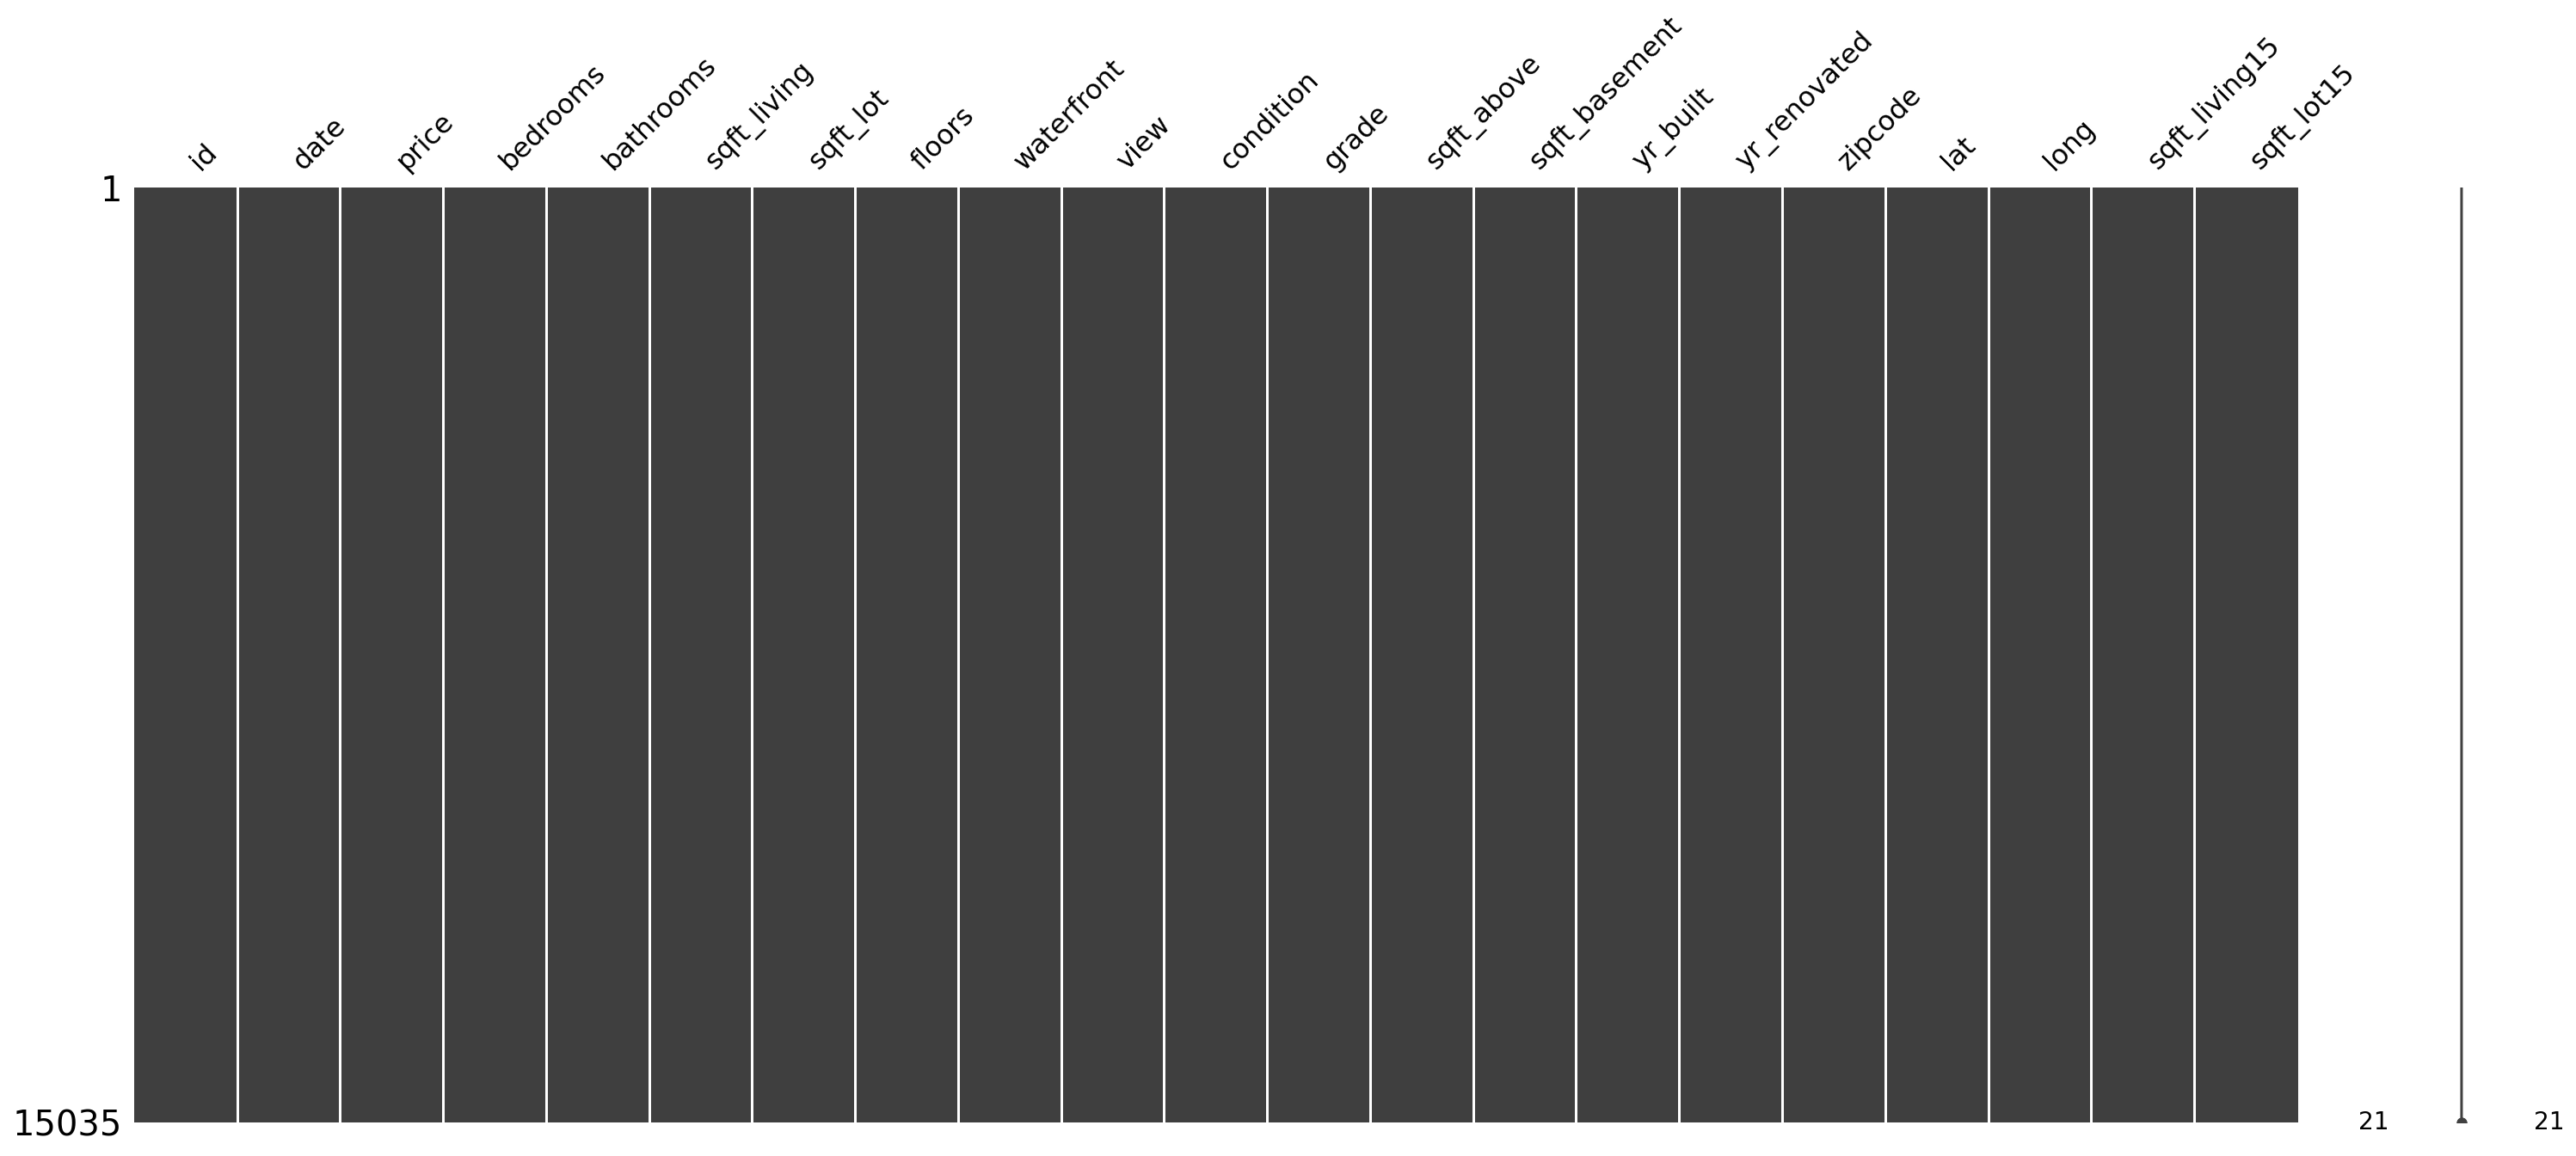

In [8]:
msno.matrix(data)

흰색으로 색칠된 부분이 보이지 않으므로 결측치가 없는 것으로 확인되지만 조금 더 자세히 확인해본다.

### 결측치의 개수 확인

In [9]:
# 1. id 컬럼에 결측치가 있는지 확인
null_check = pd.isnull(data['id'])
print(null_check)

0        False
1        False
2        False
3        False
4        False
         ...  
15030    False
15031    False
15032    False
15033    False
15034    False
Name: id, Length: 15035, dtype: bool


In [10]:
# 2. 결측치인 데이터만 뽑아내기
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [11]:
# 3. 결측치인 데이터의 개수 확인
print('{}: {}'.format('id', len(null_data.values)))

id: 0


In [12]:
# 각 컬럼별로 확인하기

for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


컬럼 별로 결측치의 개수를 출력해본 결과, 결측치가 존재하지 않는 것을 확인할 수 있다.

### 각 변수들의 분포 확인

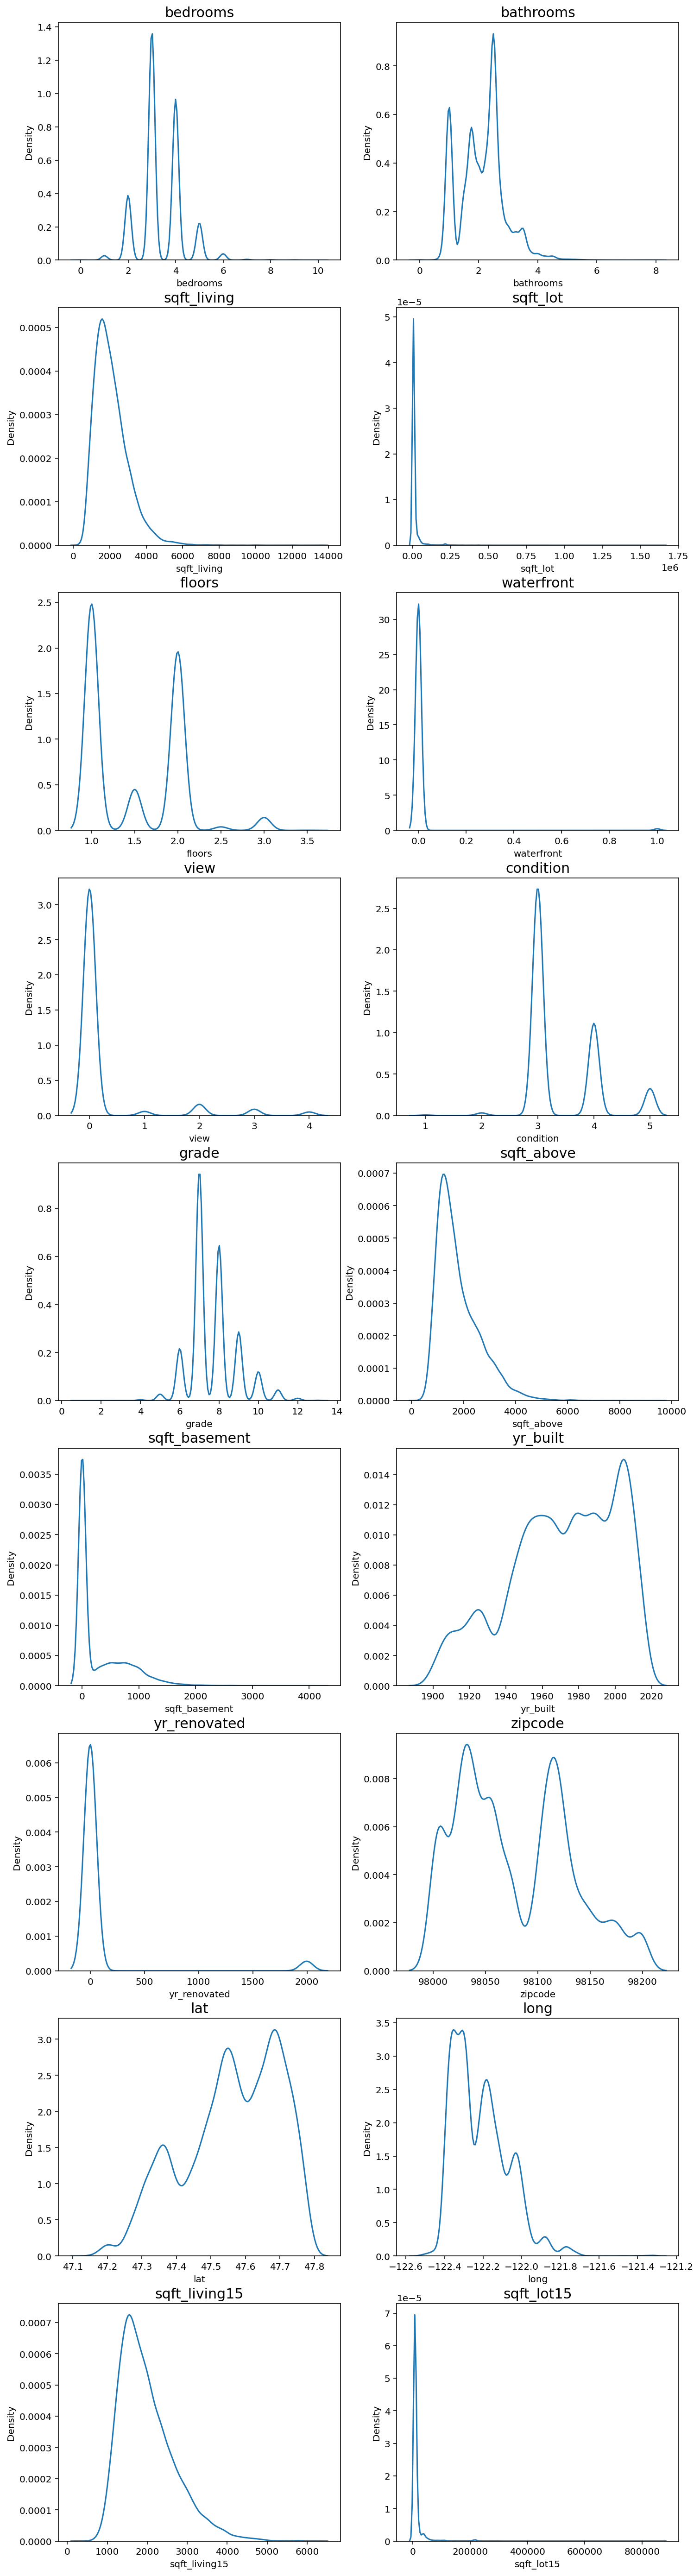

In [13]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))  

count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

한 쪽으로 치우친 경향이 보이는 'bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'yr_renovated', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15' 변수들을 log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어준다.

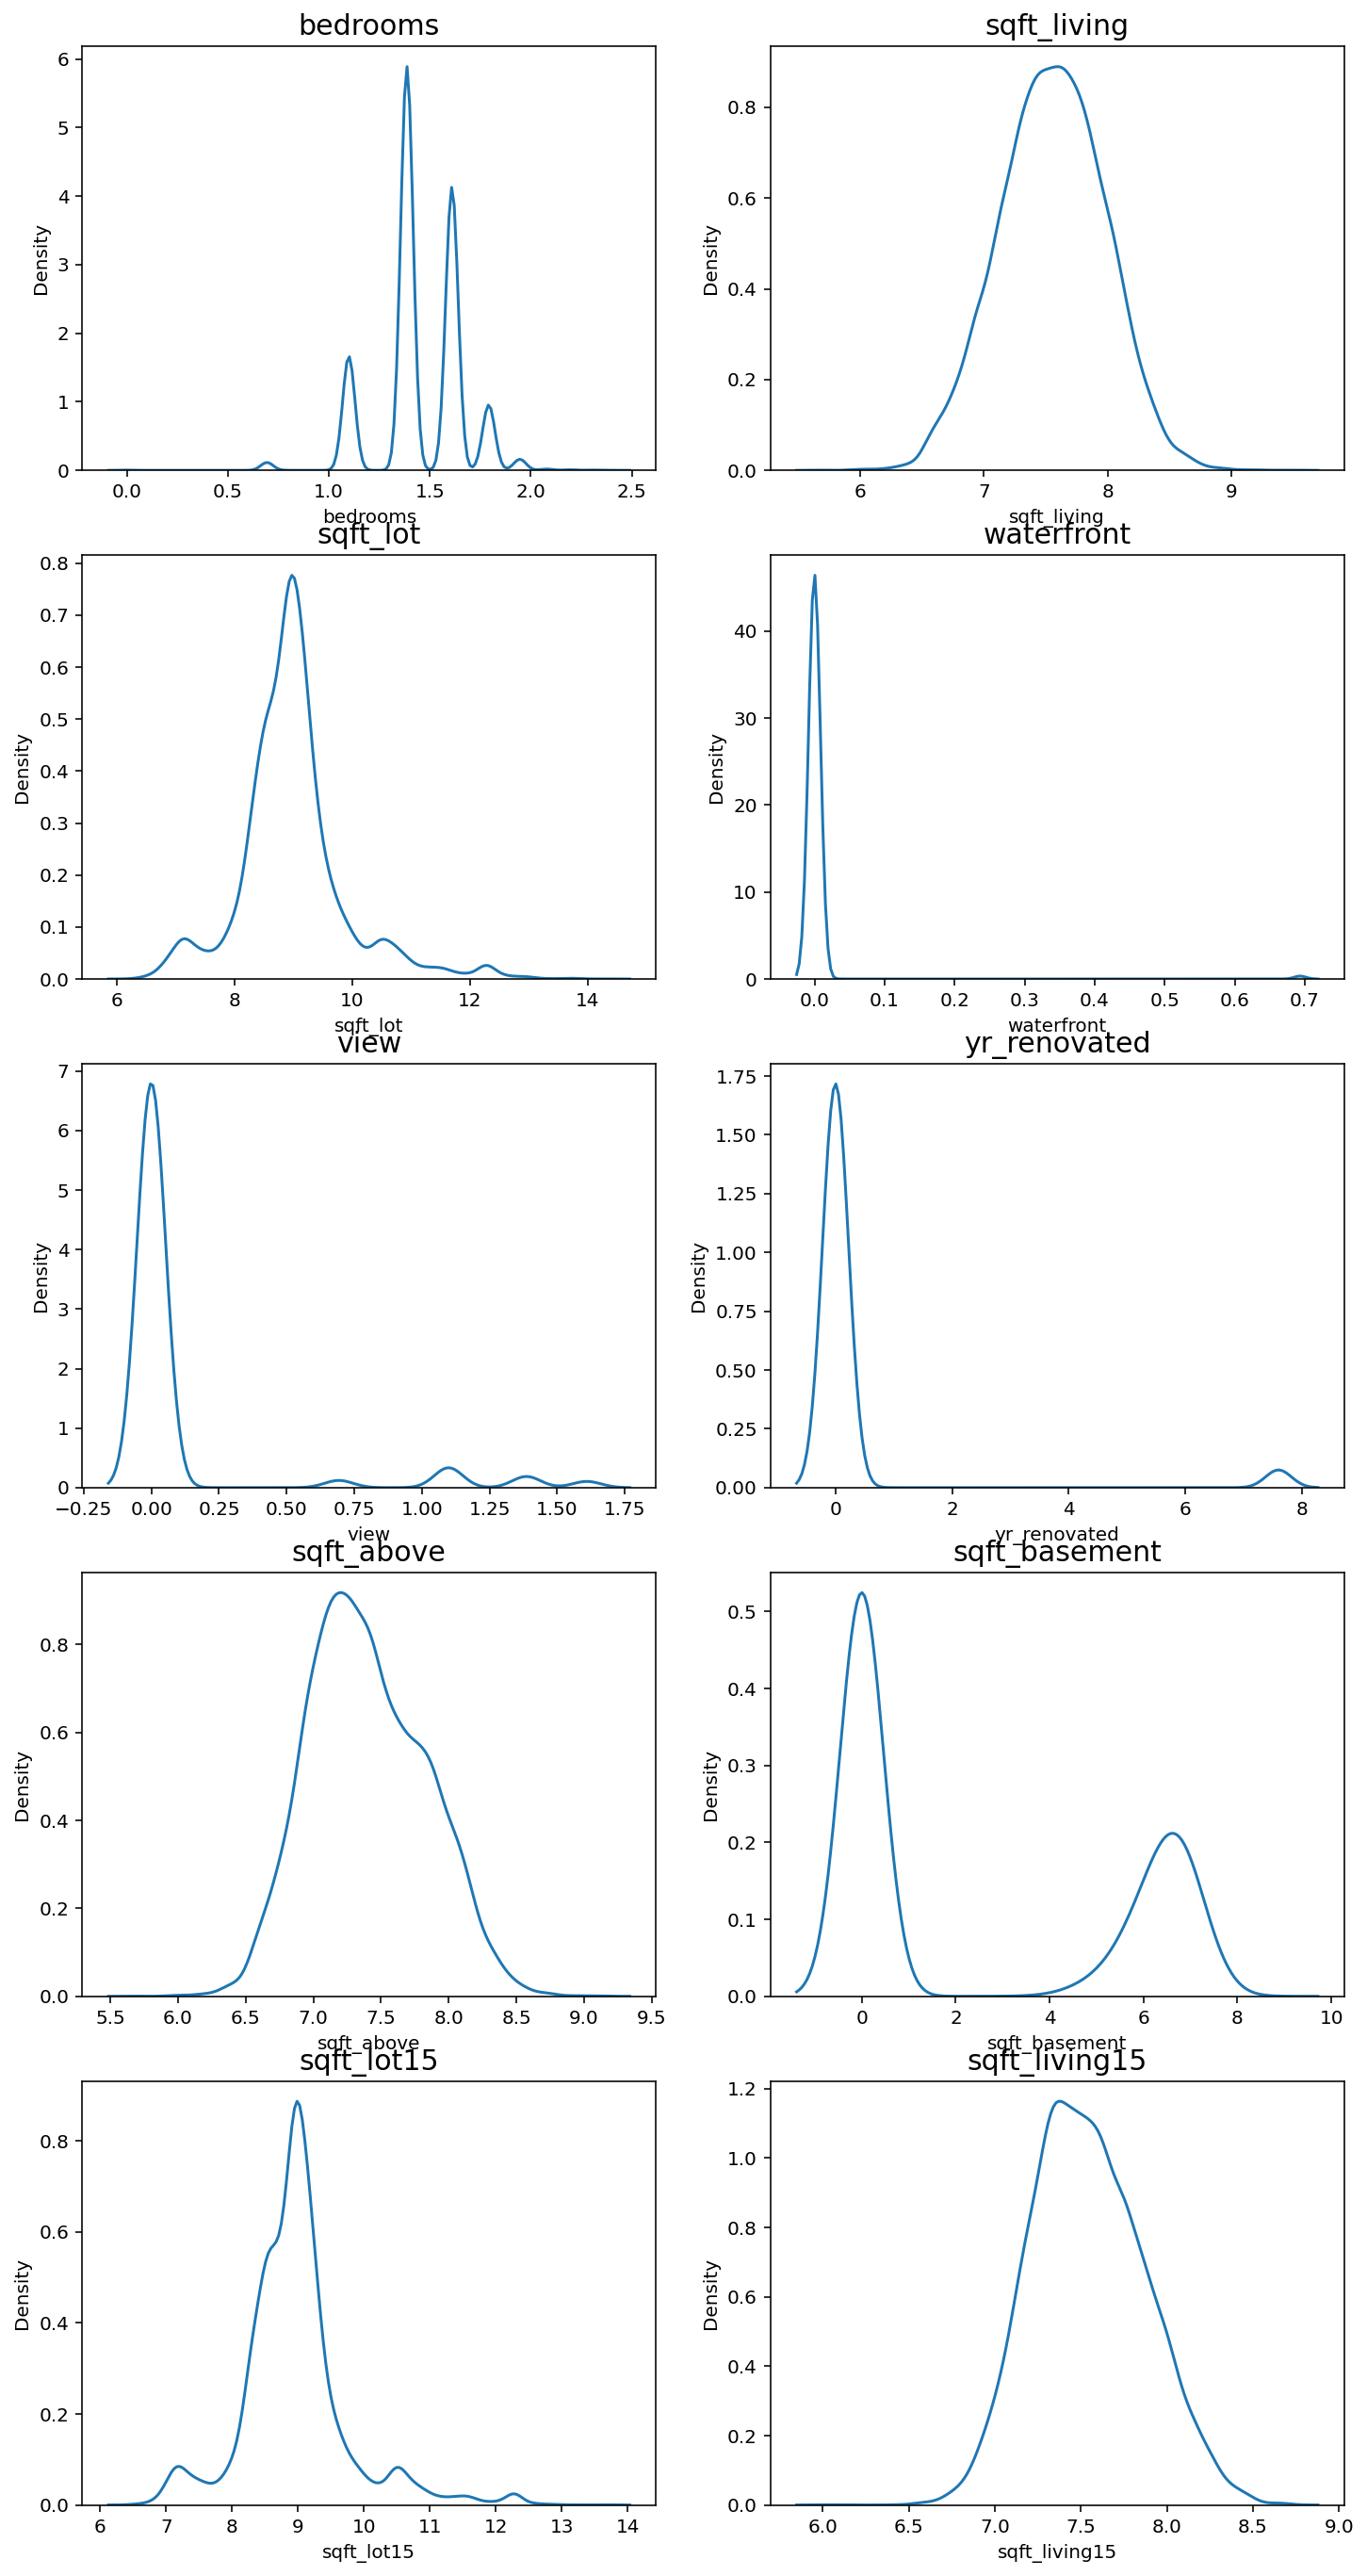

In [14]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'yr_renovated', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

fig, ax = plt.subplots(5, 2, figsize=(12, 24))
    
count = 0
for row in range(5):
    for col in range(2):
        if count == 10:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

어느 정도 치우침이 줄어든 것을 확인할 수 있다. 치우쳤다고 생각했지만 다른 한쪽에 소량의 데이터가 존재했던 변수들에 대해서는 큰 변화가 보이지 않았다.
<br>

같은 방식으로 타겟 데이터인 y의 분포도 확인해보았다.

In [15]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

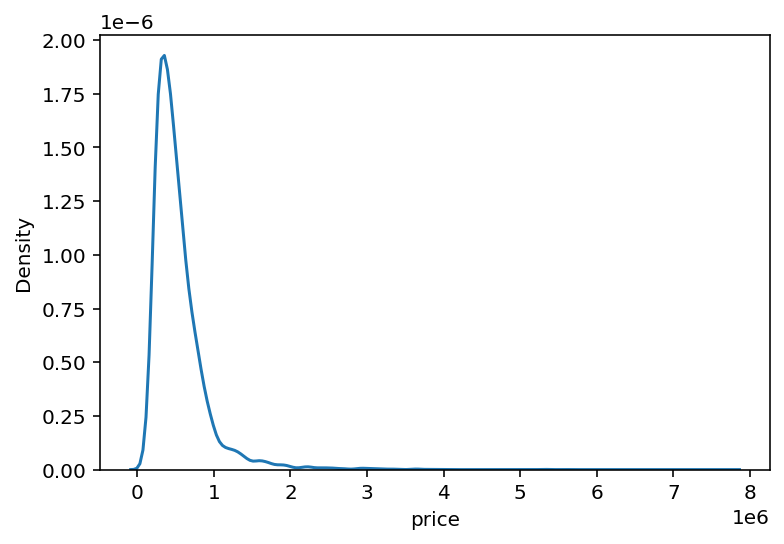

In [16]:
sns.kdeplot(y)
plt.show()

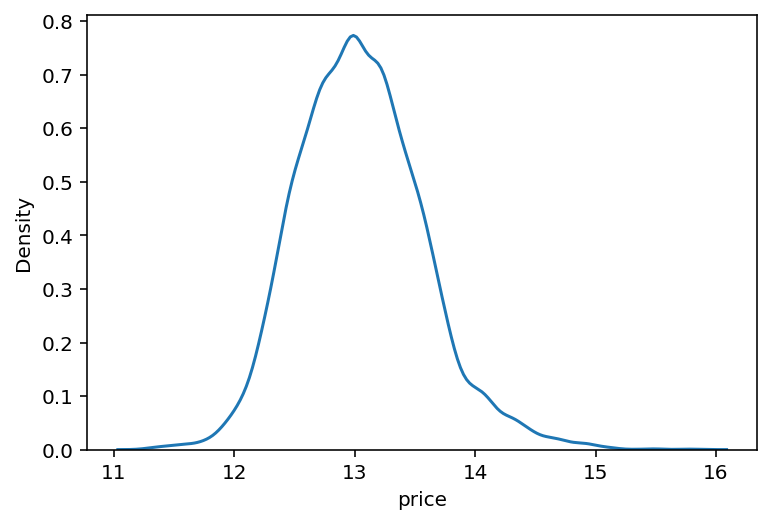

In [17]:
y = np.log1p(y)
sns.kdeplot(y)

plt.show()

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  float64
 7   view           15035 non-null  float64
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  float64
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  float64
 18  sqft_l

전체 데이터를 확인해본 결과 모두 실수 또는 정수형으로 나타내어지고 있고 결측값도 존재하지 않아 모델 학습에 문제가 되지 않을 것으로 보인다.

<hr>

## 여러 함수 정의하기

In [19]:
# 라이브러리 불러오기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# RMSE 계산을 위한 함수 정의
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

### 모델링하기

In [20]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [21]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128370.48691059356,
 'XGBRegressor': 110319.7237941824,
 'LGBMRegressor': 111906.26808847864,
 'RandomForestRegressor': 125257.99483694395}

In [22]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128370.486911
RandomForestRegressor,125257.994837
LGBMRegressor,111906.268088
XGBRegressor,110319.723794


### 그리드 탐색

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [24]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [25]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339763, -0.05502353, -0.0291739 , -0.02702434])

In [26]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073398
1,1,100,-0.055024
2,10,50,-0.029174
3,10,100,-0.027024


In [27]:
results['RMSLE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073398,0.270920
1,1,100,-0.055024,0.234571
2,10,50,-0.029174,0.170804
3,10,100,-0.027024,0.164391


In [28]:
# RMSLE가 낮은 순으로 정렬
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164391
2,10,50,-0.029174,0.170804
1,1,100,-0.055024,0.234571
0,1,50,-0.073398,0.270920


### 위 과정을 함수로 정의

In [29]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [30]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164391
2,10,50,-0.029174,0.170804
1,1,100,-0.055024,0.234571
0,1,50,-0.073398,0.270920


그리드 탐색을 진행해본 결과, max_depth=10, n_estimators=100으로 설정하는 것이 가장 성능이 좋아보인다.

In [31]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.6187806 , 13.66690392, 14.34790263, ..., 14.20917632,
       14.04760593, 13.94023205])

In [32]:
prediction = np.expm1(prediction)
prediction

array([ 821411.41833685,  861907.09407445, 1703000.1423916 , ...,
       1482403.99407002, 1261239.0150761 , 1132831.90731624])

In [33]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [34]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,8.214114e+05
1,15036,8.619071e+05
2,15037,1.703000e+06
3,15038,6.215037e+05
4,15039,6.853178e+05


In [35]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164391')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164391.csv


### 위 과정을 함수로 정의

In [36]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [37]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


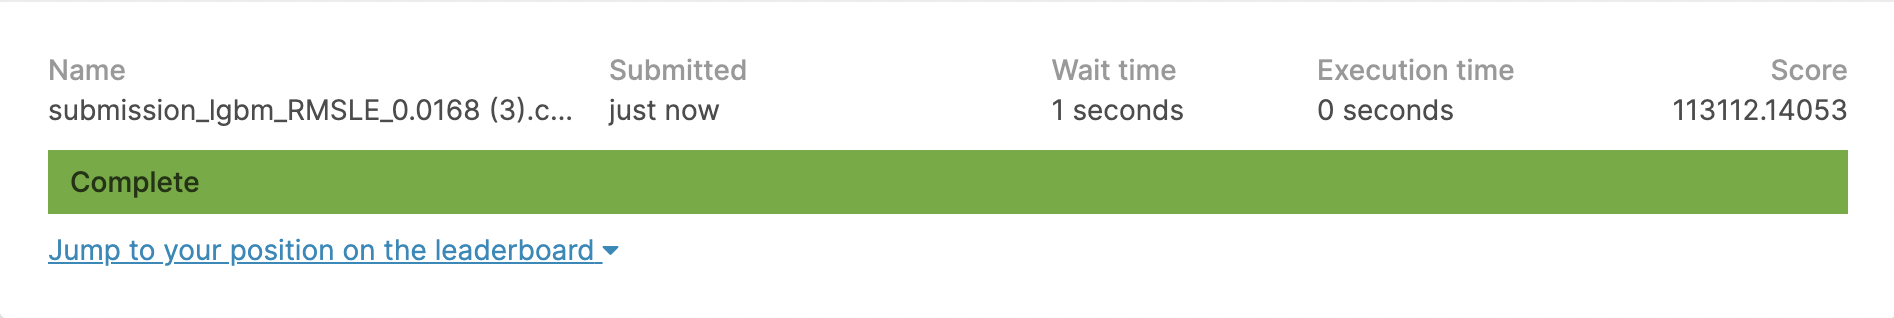

Kaggle 제출 후 점수를 확인하니 113112.14053이었다. 목표 점수에 근접해가고 있으니 좀 더 여러 방법들을 시도해봐야겠다.

<hr>

## 하이퍼 파라미터 튜닝하기


데이터를 다시 가져와 전처리를 해준다.

In [38]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']
del train['id']


test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [39]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300, 400, 500],
    'max_depth': [1, 10, 15],
}

my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


,max_depth,n_estimators,score,RMSLE
12,10,400,-0.026121,0.161619
11,10,300,-0.026127,0.161640
10,10,200,-0.026188,0.161828
13,10,500,-0.026245,0.162004
18,15,300,-0.026269,0.162079
19,15,400,-0.026318,0.162228
17,15,200,-0.026364,0.162371
20,15,500,-0.026413,0.162521
9,10,150,-0.026458,0.162660
16,15,150,-0.026605,0.163109


In [40]:
model = LGBMRegressor(max_depth=10, n_estimators=400, random_state=random_state)

save_submission(model, train, y, test, 'LGBMR', rmsle='0.0161619')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_LGBMR_RMSLE_0.0161619.csv saved!


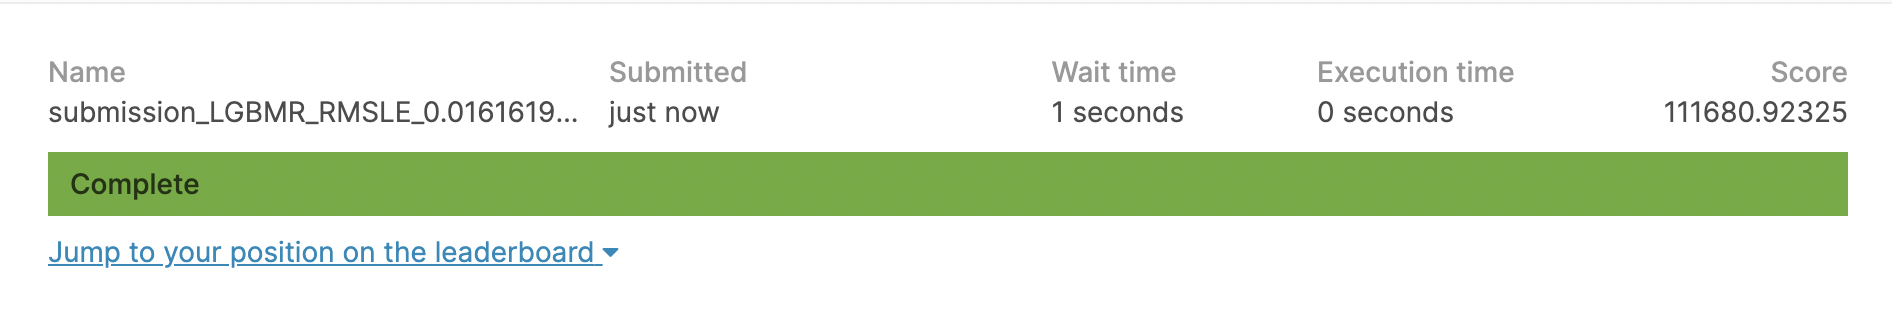

그리드 탐색을 통해 가장 성능이 좋아 보이는 max_depth=10, n_estimators=400로 하이퍼 파라미터를 수정하였다.<br> 
그 결과 Score는 많이 줄어들었지만 아직 목표 점수인 110000점에는 미치지 못했다.

### 모델 클래스 인자 추가해보기

In [41]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']
del train['id']


test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [42]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [350, 400, 450],
    'max_depth': [10, 15],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
8,0.05,10,450,-0.025986,0.161203
11,0.05,15,450,-0.026022,0.161314
7,0.05,10,400,-0.026036,0.161355
10,0.05,15,400,-0.026087,0.161513
0,0.10,10,350,-0.026110,0.161587
1,0.10,10,400,-0.026121,0.161619
6,0.05,10,350,-0.026139,0.161677
2,0.10,10,450,-0.026176,0.161791
9,0.05,15,350,-0.026194,0.161844
3,0.10,15,350,-0.026268,0.162073


In [43]:
model = LGBMRegressor(
    learning_rate=0.1, 
    max_depth=10, 
    n_estimators=450, 
    random_state=random_state
)

save_submission(model, train, y, test, 'LGBMR', rmsle='0.0161203')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_LGBMR_RMSLE_0.0161203.csv saved!


RMSLE를 낮은 순으로 정렬했을 때 learning_rate=0.05, max_depth=10, n_estimators=450가 가장 적합한 조합이라고 생각을 하여 적용시켰다. 하지만 Kaggle 점수는 오히려 129150.47168로 높아졌다. learning_rate를 기본 값인 0.1로 다시 변경을 해주니 111104.76009으로 나왔다. 목표 점수에 많이 가까워졌지만 아직 부족한 점수였다.

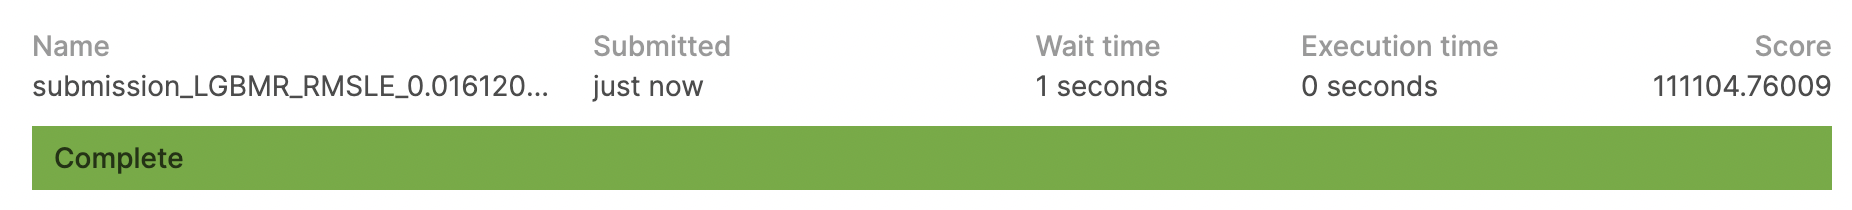

<hr>

## 모델 변경하기

In [44]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']
del train['id']


test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [45]:
model = XGBRegressor(
    learning_rate =0.1,
    max_depth=10,
    n_estimators=450,
    
)
save_submission(model, train, y, test, 'XGB', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGB_RMSLE_0.0168.csv saved!


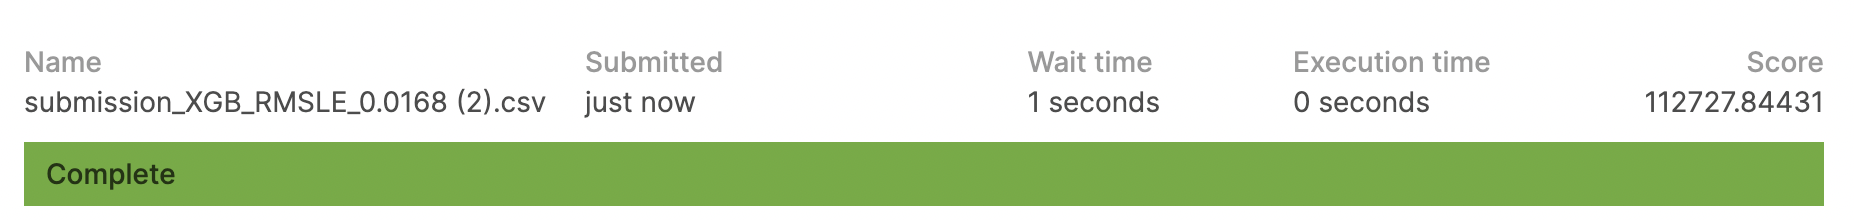

점수가 다시 높아졌다. 하이퍼 파라미터의 튜닝을 다시 해줄 필요가 있어 보인다.

### 하이퍼 파라미터 다시 수정

XGBRegressor 모델에서 그리드를 탐색하는 과정에서 시간이 과하게 오래 걸리거나 오류가 계속 발생하는 문제가 생겼다. 따라서 적절한 하이퍼 파라미터를 직접 찾아보면서 진행하였다.

In [46]:
model = XGBRegressor(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
)
save_submission(model, train, y, test, 'XGB', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGB_RMSLE_0.0168.csv saved!


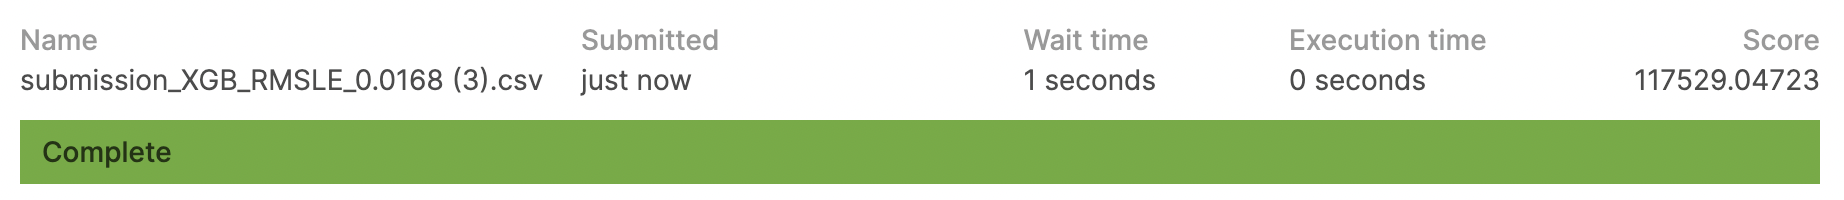

In [47]:
model = XGBRegressor(
    learning_rate =0.1,
    n_estimators=500,
    max_depth=10,
)
save_submission(model, train, y, test, 'XGB', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGB_RMSLE_0.0168.csv saved!


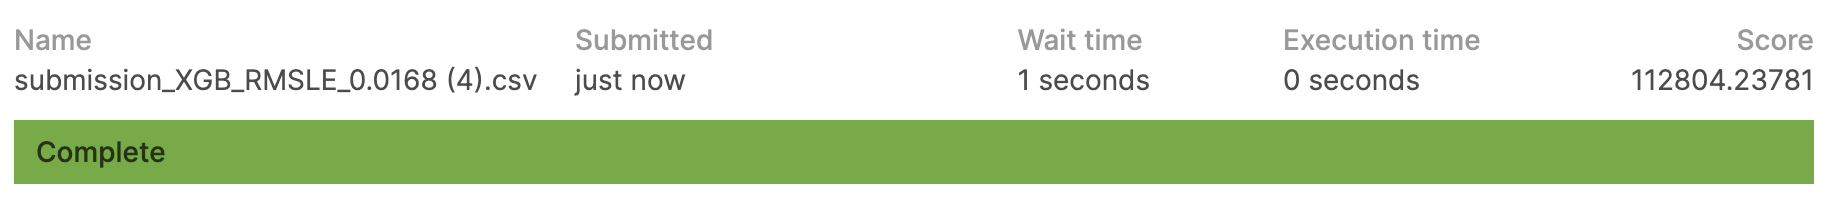

In [48]:
model = XGBRegressor(
    learning_rate =0.1,
    n_estimators=500,
    max_depth=5,
)
save_submission(model, train, y, test, 'XGB', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGB_RMSLE_0.0168.csv saved!


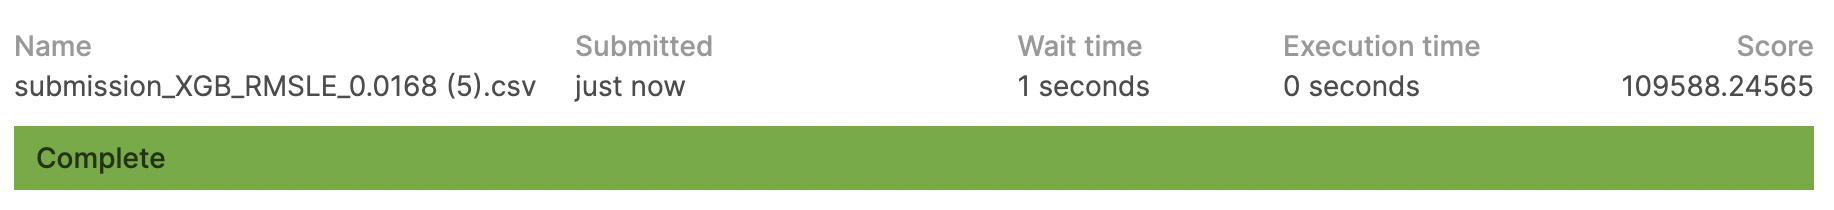

드디어 110000점 밑으로 점수가 내려갔다! 더 내려보고 싶은 욕심이 생겨 튜닝 작업을 조금 더 진행했다.

In [49]:
model = XGBRegressor(
    learning_rate =0.1,
    n_estimators=600,
    max_depth=5,
)
save_submission(model, train, y, test, 'XGB', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGB_RMSLE_0.0168.csv saved!


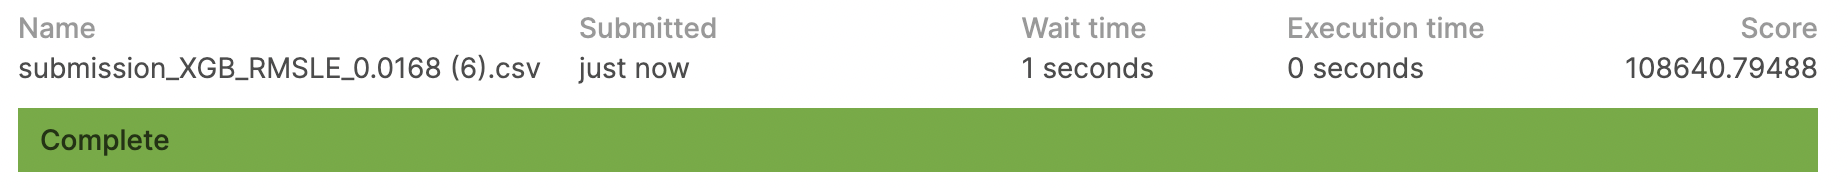

In [50]:
model = XGBRegressor(
    learning_rate =0.09,
    n_estimators=600,
    max_depth=5,
)
save_submission(model, train, y, test, 'XGB', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGB_RMSLE_0.0168.csv saved!


### Randomized Search 사용해보기

사이킷런에서 RandomizedSearchCV를 불러와 하이퍼 파라미터 튜닝을 해볼 예정이다. 먼저 사용하기 편하게 함수로 만들어준다.

In [51]:
from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint 

def my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=5):
    # RandomizedSearchCV 모델로 초기화
    rnd_model = RandomizedSearchCV(model, param_distributions=param_distribs, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    rnd_model.fit(train, y)

    # 결과값 저장
    params = rnd_model.cv_results_['params']
    score = rnd_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

위에서 만든 함수를 앞서 목표 점수에 도달하지 못했던 LGBMRegressor모델에 적용시켜 보았다. n_estimators의 범위는 100부터 500까지로 지정했고 max_features의 범위는 5에서 15까지로 지정했다.

In [52]:
param_distribs = {
    'n_estimators': randint(low=100, high=500),
    'max_features': randint(low=5, high=15),
}

model = LGBMRegressor(random_state=random_state)
my_RandomSearch(model, train, y, param_distributions=param_distribs, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Unknown parameter: max_features


,max_features,n_estimators,score,RMSLE
5,10,264,-0.026109,0.161582
8,7,296,-0.026111,0.161590
9,14,248,-0.026134,0.161660
1,8,363,-0.026162,0.161746
6,6,219,-0.026197,0.161854
0,6,450,-0.026272,0.162086
2,13,164,-0.026374,0.162400
4,12,160,-0.026384,0.162430
3,10,142,-0.026503,0.162798
7,6,120,-0.026730,0.163493


결과를 확인하니 max_features=11, n_estimators=310일 때의 RMSLE가 가장 낮게 나왔다. 이를 모델에 적용시켜 점수를 확인해보았다.

In [53]:
model = LGBMRegressor(
    learning_rate=0.1, 
    max_features=11, 
    n_estimators=310, 
    random_state=random_state
)

save_submission(model, train, y, test, 'LGBMR', rmsle='0.0161539')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_LGBMR_RMSLE_0.0161539.csv saved!
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=400; total time=   1.0s
[CV] END ......................max_depth=1, n_estimators=400; total time=   1.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.7s
[CV] END ................

[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.7s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.3s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=200; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=300; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=300; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=500; total time=   1.1s
[CV] END ......................max_depth=1, n_estimators=500; total time=   1.4s
[CV] END ...................

[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=300; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=300; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.6s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.6s
[CV] END ...................

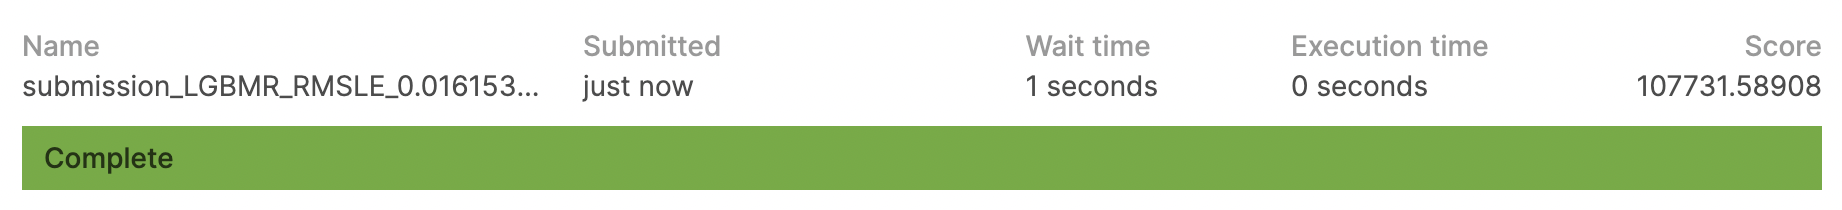

Kaggle 점수는 107731.58908로 목표 점수를 넘기는데 성공했다. 앞서 진행했던 그리드 탐색보다 최적의 조합을 찾는데 효과적이었다.

<hr>

# <프로젝트 회고>
<br>
이전부터 Kaggle에 대해서는 알고 있었지만 직접 참여를 해본 것은 이 프로젝트가 처음이었다. 물론 이미 종료된 대회에 참가하게 되었지만 Kaggle의 전체적인 프로세스를 배울 수 있는 좋은 기회였다. 이번 대회에서는 베이스라인이 주어져 있어서 전체적인 과정을 어떻게 진행할지에 대한 고민보다는 더 좋은 성능을 위해 어떻게 해야할지에 대한 고민을 더 많이 한 것 같다. 먼저 노드를 따라 만든 첫 모델의 점수는 이미 120000점을 넘어버렸다. 목표 점수는 110000점 이하의 점수를 얻는 것이었기 때문에 더 좋은 성능을 위해 다양한 시도를 해보았다.
<br><br>
먼저 하이퍼 파라미터 튜닝을 해보았다. 그리드 탐색을 통해 가장 성능이 좋아 보이는 max_depth=10, n_estimators=400로 하이퍼 파라미터를 수정하였다.
그 결과 Score는 많이 줄어들었지만 아직 목표 점수인 110000점에는 미치지 못했다. 그 다음은 클래스 인자를 추가하여 보았다. RMSLE를 낮은 순으로 정렬했을 때 learning_rate=0.05, max_depth=10, n_estimators=450가 가장 적합한 조합이라고 생각을 하여 적용시켰다. 하지만 Kaggle 점수는 오히려 129150.47168로 높아졌다. learning_rate를 기본 값인 0.1로 다시 변경을 해주니 111104.76009으로 나왔다. 목표 점수에 많이 가까워졌지만 아직 부족한 점수였다. RMSLE가 낮을수록 성능이 좋다는 것을 의미한다고 알고 있었는데 Kaggle 점수는 높아져서 원인을 찾아보려고 했으나 찾지 못했다. 그 다음은 LGBMRegressor이 아닌 XBGRegressor을 통해 학습시킨 모델로 제출을 해보았다. n_estimators=600, max_depth=5로 했을 때의 조합이 가장 성능이 좋았고 Kaggle의 점수는 108640.79488점으로 목표 점수에 도달했다.
<br><br>
최적의 하이퍼 파라미터 조합을 찾기 위해 그리드 탐색을 진행했는데 랜덤 탐색으로도 한번 시도해보고 싶어졌다. 그리드 탐색은 특정 값을 정해두어야 하기 때문에 최적의 조합을 놓치기 쉽기 때문이다. LGBMRegressor로 학습한 모델의 점수가 110000점을 못 넘었기에 LGBMRegressor 모델로 시도해보았다. n_estimators의 범위는 100부터 500까지로 지정했고 max_features의 범위는 5에서 15까지로 지정했다. 그 결과, max_features=11, n_estimators=310일 때의 RMSLE가 가장 낮게 나왔고 Kaggle 점수는 107731.58908점이 나왔다.
<br><br>
목표 점수에는 달성했지만 다른 사람들의 리더보드를 보니 휠씬 score가 낮은 사람들이 많았다. score를 낮출 수 있는 방법을 조금 더 연구해보고 다른 사람들의 코드도 참고해보면 많은 도움이 될 것 같다. 앞으로 자주 Kaggle을 이용하면서 다양한 예제들을 접하면서 실력을 키워야겠다.